In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score,
    homogeneity_completeness_v_measure
)

In [2]:
output_dir = "output"
competitor_dir = "output_competitors"

In [3]:
# clear empty directories in the output competitors dir
def clear_empty_directories(directory):
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            if not os.listdir(dir_path):  # Check if directory is empty
                os.rmdir(dir_path)  # Remove empty directory

clear_empty_directories(competitor_dir)


In [4]:
methods = {}
for dim in ["1d", "2d", "3d"]:
    dim_path = os.path.join(competitor_dir, dim)
    if not os.path.isdir(dim_path):
        continue
    methods[dim] = []
    for method in os.listdir(dim_path):
        method_path = os.path.join(dim_path, method)
        if os.path.isdir(method_path):
            # Check that the method folder contains 'wave' or 'gauss' subdirs with a memberships.csv
            valid = any(
                os.path.isfile(os.path.join(method_path, subdir, "memberships.csv"))
                for subdir in ["gauss"] #"wave", , "warped_bump", "spline_like"
            )
            if valid:
                methods[dim].append(method)
    methods[dim].sort()  # Optional: alphabetically sort methods

In [5]:
# Manually remove some labels
to_remove_1d = ["funFEM", "fda_usc"]
to_remove_2d = ["scikit_hog", "tensor_pca"]
to_remove_3d = ["tensor_pca"]

# methods["1d"] = [m for m in methods["1d"] if m not in to_remove_1d]
# methods["2d"] = [m for m in methods["2d"] if m not in to_remove_2d]
# methods["3d"] = [m for m in methods["3d"] if m not in to_remove_3d]

In [6]:
better_labels = {
    "reg": "Regularized Functional K-means",
    "non_reg": "Functional K-means",
    "funFEM": "funFEM",
    "fda_usc": "fda.usc",
    "scikit_hog": "HOG + K-means",
    "tensor_pca": "tensor-PCA + K-means",
    "fdacluster": "fdacluster",
    "geomstats": "geomstats + K-means",
    "mv": "K-means",
    "scikit": "scikit Functional K-means",
    "scikit_fpca": "fPCA + K-means",
    "scikit_pca": "PCA + K-means",
    "smooth_fda_usc": "Smoothing + fda.usc",
    "smooth_fdacluster": "Smoothing + fdacluster",
    "smooth_geomstats": "Smoothing + geomstats + K-means",
    "smooth_funFEM": "Smoothing + funFEM",
    "smooth_scikit_hog": "Smoothing + HOG + K-means",
    "smooth_scikit": "Smoothing + scikit Functional K-means",
    "tensor_pca": "tensor-PCA + K-means",
    "smooth_tensor_pca": "Smoothing + tensor-PCA + K-means",
    "reg_reg": "Regularized Functional K-means",
    "dineof_fdacluster": "DINEOF + fdacluster",
    "tps_fdacluster": "Cubic Splines + fdacluster",
    "dineof_geomstats": "DINEOF + geomstats",
    "tps_geomstats": "TPS + geomstats",
    "dineof_scikit": "DINEOF + scikit Functional K-means",
    "tps_scikit": "TPS + scikit Functional K-means"
}

# Load generation Params

In [7]:
dir = "output"
with open("./data/gen_log.txt") as f:
    text = f.read()

# param_pat = re.compile(r"(\w+)\s*[:=]\s*(\d+)")
# params = {key: int(val) for key, val in param_pat.findall(text)}

comb_match = re.search(r'^combination\s*[:=]\s*(\d+)', text, re.MULTILINE)
combination = comb_match.group(1) if comb_match else None

scalar_keys = ("n_obs_per_clust", "n_clust", "N", "seed")
scalar_pat  = rf'^({"|".join(scalar_keys)})\s*[:=]\s*(\d+)\s*$'
scalars = {k: int(v) for k, v in re.findall(scalar_pat, text, re.MULTILINE)}

n_obs_per_clust = scalars["n_obs_per_clust"]
n_clust         = scalars["n_clust"]
N               = scalars["N"]
seed            = scalars["seed"]

print("combination     =", combination)        
print("n_obs_per_clust =", n_obs_per_clust)    
print("n_clust         =", n_clust)            
print("N               =", N)                  
print("seed            =", seed)               

combination     = 021102
n_obs_per_clust = 30
n_clust         = 3
N               = 50
seed            = 773623948


In [8]:
data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

labels_true = np.array([i for i in range(n_clust) for _ in range(n_obs_per_clust)])

# 1D

In [9]:
dim = "1d"
for type in ["gauss"]: #"wave", , "warped_bump", "spline_like"
    for met in ["reg", "non_reg"]:
        filepath = os.path.join(output_dir, met, dim, type, "memberships.csv")
        data[dim][met][type]["memberships"] = pd.read_csv(filepath, header=None)
    for met in methods[dim]:
        filepath = os.path.join(competitor_dir, dim, met, type, "memberships.csv")
        data[dim][met][type]["memberships"] = pd.read_csv(filepath, header=None)

In [10]:
metrics = ["ari", "nmi", "fmi", "homogeneity", "completeness", "v_measure"]

for typ in ["reg", "non_reg"] + methods[dim]:
    for curve in ["gauss"]: #, "wave", "warped_bump", "spline_like"
        labels_pred = data[dim][typ][curve]["memberships"]
        N = labels_pred.shape[0]

        # Compute raw metrics for each run
        data[dim][typ][curve]["ari"]["raw"] = [adjusted_rand_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        data[dim][typ][curve]["nmi"]["raw"] = [normalized_mutual_info_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        data[dim][typ][curve]["fmi"]["raw"] = [fowlkes_mallows_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]

        hcv = [homogeneity_completeness_v_measure(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        h, c, v = zip(*hcv)
        data[dim][typ][curve]["homogeneity"]["raw"] = list(h)
        data[dim][typ][curve]["completeness"]["raw"] = list(c)
        data[dim][typ][curve]["v_measure"]["raw"] = list(v)

        # Compute means
        for m in metrics:
            data[dim][typ][curve][m]["mean"] = np.mean(data[dim][typ][curve][m]["raw"])

rows = []
for curve in ["gauss"]: #, "wave", "warped_bump", "spline_like"
    for typ in ["reg", "non_reg"] + methods[dim]:
        row = {
            "Type": typ,
            "Curve": curve,
        }
        for m in metrics:
            row[m.upper()] = data[dim][typ][curve][m]["mean"]
        rows.append(row)

df = pd.DataFrame(rows)
df

,Type,Curve,ARI,NMI,FMI,HOMOGENEITY,COMPLETENESS,V_MEASURE
0,reg,gauss,0.652798,0.672490,0.770517,0.664860,0.682304,0.672490
1,non_reg,gauss,0.568463,0.606162,0.715823,0.596581,0.617306,0.606162
2,fda_usc,gauss,0.230218,0.289930,0.510414,0.276434,0.305961,0.289930
3,fdacluster,gauss,0.503511,0.548308,0.676900,0.534533,0.564469,0.548308
4,funFEM,gauss,0.001742,0.022638,0.340471,0.022206,0.023120,0.022638
5,mv,gauss,0.561910,0.592452,0.707923,0.588489,0.596799,0.592452
6,scikit,gauss,0.470457,0.513846,0.654673,0.500612,0.529111,0.513846
7,scikit_fpca,gauss,0.473952,0.514136,0.655969,0.502563,0.527513,0.514136
8,scikit_pca,gauss,0.515227,0.558314,0.684253,0.545122,0.573690,0.558314
9,smooth_fda_usc,gauss,0.401391,0.484576,0.621371,0.458437,0.516407,0.484576


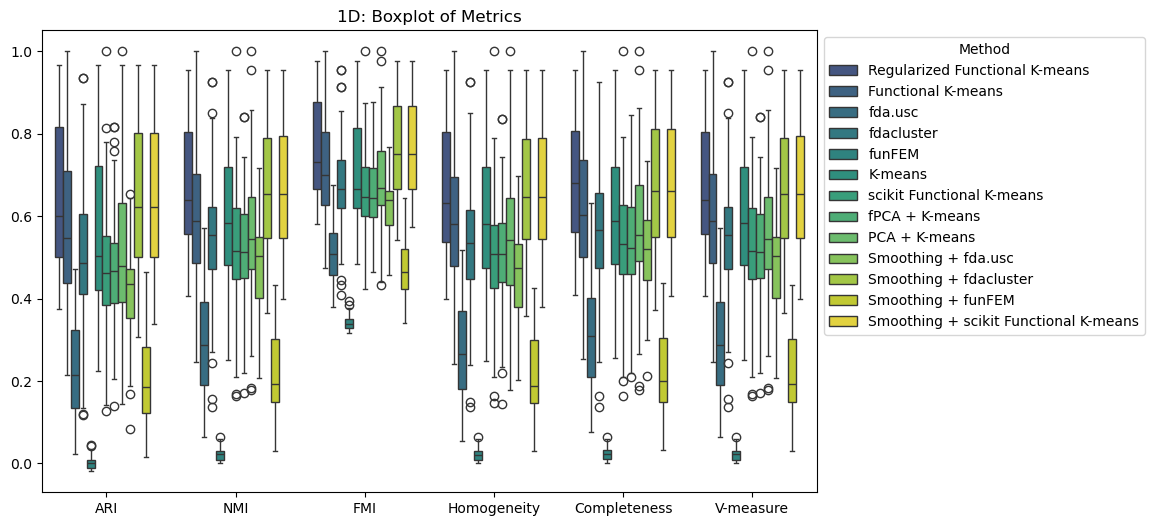

In [11]:
#create dataframe for boxplots
# df_box = pd.DataFrame(columns=["Type", "Curve", "Metric", "Value"])
df_box = []
for curve in ["gauss"]: #, "wave", "warped_bump", "spline_like"
    for typ in ["reg", "non_reg"] + methods[dim]:
        for m in metrics:
            values = data[dim][typ][curve][m]["raw"]
            for value in values:
                df_box.append({
                    "Type": better_labels[typ],
                    "Curve": curve,
                    "Metric": m.upper() if m in ["ari", "nmi", "fmi"] else "V-measure" if m == "v_measure" else m.capitalize(),
                    "Value": value
                })

# Convert to DataFrame
df_box = pd.DataFrame(df_box)

light_viridis = sns.color_palette("viridis", as_cmap=True)
colors = [light_viridis(x) for x in np.linspace(0.25, 1, len(df_box["Type"].unique()))]

# Create boxplots for each curve
for curve in ["gauss"]: #, "wave", "warped_bump", "spline_like"
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Metric", y="Value", hue="Type", data=df_box[df_box["Curve"] == curve], palette=colors)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f"{dim.upper()}: Boxplot of Metrics")
    plt.legend(title="Method", bbox_to_anchor=(1, 1), loc='upper left')
    # plt.tight_layout()
    plt.savefig(f"{dim}_boxplot.png", bbox_inches='tight')
    plt.show()


In [12]:
# save pd table as a csv file
# df.to_csv(f"competitors_{dim}.csv", index=False)

# 2D

In [13]:
dim = "2d"
for type in ["gauss"]: #"wave", , "warped_bump"
    for met in ["reg", "non_reg"]:
        filepath = os.path.join(output_dir, met, dim, type, "memberships.csv")
        data[dim][met][type]["memberships"] = pd.read_csv(filepath, header=None)
    for met in methods[dim]:
        filepath = os.path.join(competitor_dir, dim, met, type, "memberships.csv")
        data[dim][met][type]["memberships"] = pd.read_csv(filepath, header=None)

In [14]:
metrics = ["ari", "nmi", "fmi", "homogeneity", "completeness", "v_measure"]

for typ in ["reg", "non_reg"] + methods[dim]:
    for curve in ["gauss"]: #, "wave", "warped_bump"
        labels_pred = data[dim][typ][curve]["memberships"]
        N = labels_pred.shape[0]

        # Compute raw metrics for each run
        data[dim][typ][curve]["ari"]["raw"] = [adjusted_rand_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        data[dim][typ][curve]["nmi"]["raw"] = [normalized_mutual_info_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        data[dim][typ][curve]["fmi"]["raw"] = [fowlkes_mallows_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]

        hcv = [homogeneity_completeness_v_measure(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        h, c, v = zip(*hcv)
        data[dim][typ][curve]["homogeneity"]["raw"] = list(h)
        data[dim][typ][curve]["completeness"]["raw"] = list(c)
        data[dim][typ][curve]["v_measure"]["raw"] = list(v)

        # Compute means
        for m in metrics:
            data[dim][typ][curve][m]["mean"] = np.mean(data[dim][typ][curve][m]["raw"])

rows = []
for curve in ["gauss"]: #, "wave", "warped_bump"
    for typ in ["reg", "non_reg"] + methods[dim]:
        row = {
            "Type": typ,
            "Curve": curve,
        }
        for m in metrics:
            row[m.upper()] = data[dim][typ][curve][m]["mean"]
        rows.append(row)

df = pd.DataFrame(rows)
df

,Type,Curve,ARI,NMI,FMI,HOMOGENEITY,COMPLETENESS,V_MEASURE
0,reg,gauss,0.925243,0.931312,0.950138,0.930079,0.932595,0.931312
1,non_reg,gauss,0.719482,0.762474,0.817673,0.749265,0.778767,0.762474
2,geomstats,gauss,0.655849,0.706508,0.772200,0.699076,0.714950,0.706508
3,mv,gauss,0.782704,0.808172,0.854478,0.806177,0.810235,0.808172
4,scikit,gauss,0.539254,0.598212,0.702479,0.581701,0.617846,0.598212
5,scikit_hog,gauss,-0.000823,0.022726,0.361647,0.021334,0.024491,0.022726
6,scikit_pca,gauss,0.550140,0.612822,0.710340,0.591428,0.638554,0.612822
7,smooth_geomstats,gauss,0.900313,0.906755,0.933468,0.905324,0.908275,0.906755
8,smooth_scikit,gauss,0.936771,0.941268,0.957486,0.940879,0.941660,0.941268
9,smooth_scikit_hog,gauss,0.874709,0.886859,0.917670,0.882829,0.891524,0.886859


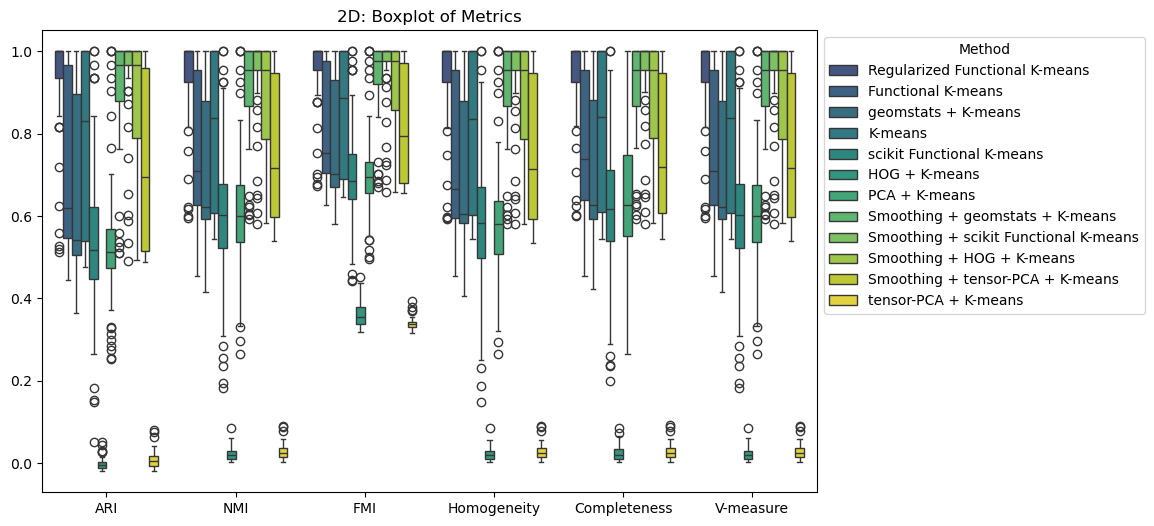

In [15]:
#create dataframe for boxplots
# df_box = pd.DataFrame(columns=["Type", "Curve", "Metric", "Value"])
df_box = []
for curve in ["gauss"]: #, "wave", "warped_bump"
    for typ in ["reg", "non_reg"] + methods[dim]:
        for m in metrics:
            values = data[dim][typ][curve][m]["raw"]
            for value in values:
                df_box.append({
                    "Type": better_labels[typ],
                    "Curve": curve,
                    "Metric": m.upper() if m in ["ari", "nmi", "fmi"] else "V-measure" if m == "v_measure" else m.capitalize(),
                    "Value": value
                })

# Convert to DataFrame
df_box = pd.DataFrame(df_box)

light_viridis = sns.color_palette("viridis", as_cmap=True)
colors = [light_viridis(x) for x in np.linspace(0.25, 1, len(df_box["Type"].unique()))]

# Create boxplots for each curve
for curve in ["gauss"]: #, "wave", "warped_bump"
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Metric", y="Value", hue="Type", data=df_box[df_box["Curve"] == curve], palette=colors)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f"{dim.upper()}: Boxplot of Metrics")
    plt.legend(title="Method", bbox_to_anchor=(1, 1), loc='upper left')
    # plt.tight_layout()
    plt.savefig(f"{dim}_boxplot.png", bbox_inches='tight')
    plt.show()


In [16]:
# save pd table as a csv file
# df.to_csv(f"competitors_{dim}.csv", index=False)

# 3D

In [17]:
dim = "3d"
for type in ["gauss"]: #"wave", 
    for met in ["reg", "non_reg"]:
        filepath = os.path.join(output_dir, met, dim, type, "memberships.csv")
        data[dim][met][type]["memberships"] = pd.read_csv(filepath, header=None)
    for met in methods[dim]:
        filepath = os.path.join(competitor_dir, dim, met, type, "memberships.csv")
        data[dim][met][type]["memberships"] = pd.read_csv(filepath, header=None)

In [18]:
metrics = ["ari", "nmi", "fmi", "homogeneity", "completeness", "v_measure"]

for typ in ["reg", "non_reg"] + methods[dim]:
    for curve in ["gauss"]: #, "wave"
        labels_pred = data[dim][typ][curve]["memberships"]
        N = labels_pred.shape[0]

        # Compute raw metrics for each run
        data[dim][typ][curve]["ari"]["raw"] = [adjusted_rand_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        data[dim][typ][curve]["nmi"]["raw"] = [normalized_mutual_info_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        data[dim][typ][curve]["fmi"]["raw"] = [fowlkes_mallows_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]

        hcv = [homogeneity_completeness_v_measure(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
        h, c, v = zip(*hcv)
        data[dim][typ][curve]["homogeneity"]["raw"] = list(h)
        data[dim][typ][curve]["completeness"]["raw"] = list(c)
        data[dim][typ][curve]["v_measure"]["raw"] = list(v)

        # Compute means
        for m in metrics:
            data[dim][typ][curve][m]["mean"] = np.mean(data[dim][typ][curve][m]["raw"])

rows = []
for curve in ["gauss"]: #, "wave"
    for typ in ["reg", "non_reg"] + methods[dim]:
        row = {
            "Type": typ,
            "Curve": curve,
        }
        for m in metrics:
            row[m.upper()] = data[dim][typ][curve][m]["mean"]
        rows.append(row)

df = pd.DataFrame(rows)
df

,Type,Curve,ARI,NMI,FMI,HOMOGENEITY,COMPLETENESS,V_MEASURE
0,reg,gauss,0.915835,0.931249,0.946224,0.924953,0.938650,0.931249
1,non_reg,gauss,-0.000247,0.040209,0.557924,0.022337,0.201193,0.040209
2,geomstats,gauss,0.322646,0.457562,0.624877,0.399301,0.549807,0.457562
3,mv,gauss,0.474367,0.644964,0.697095,0.574832,0.739053,0.644964
4,scikit,gauss,-0.000247,0.040209,0.557924,0.022337,0.201193,0.040209
5,scikit_pca,gauss,-0.000247,0.040209,0.557924,0.022337,0.201193,0.040209
6,smooth_geomstats,gauss,0.929862,0.938500,0.953873,0.935596,0.941577,0.938500
7,smooth_scikit,gauss,0.945460,0.956947,0.965286,0.952523,0.962050,0.956947
8,smooth_tensor_pca,gauss,0.770735,0.808510,0.848042,0.802486,0.815014,0.808510
9,tensor_pca,gauss,0.008164,0.030127,0.344945,0.029293,0.031044,0.030127


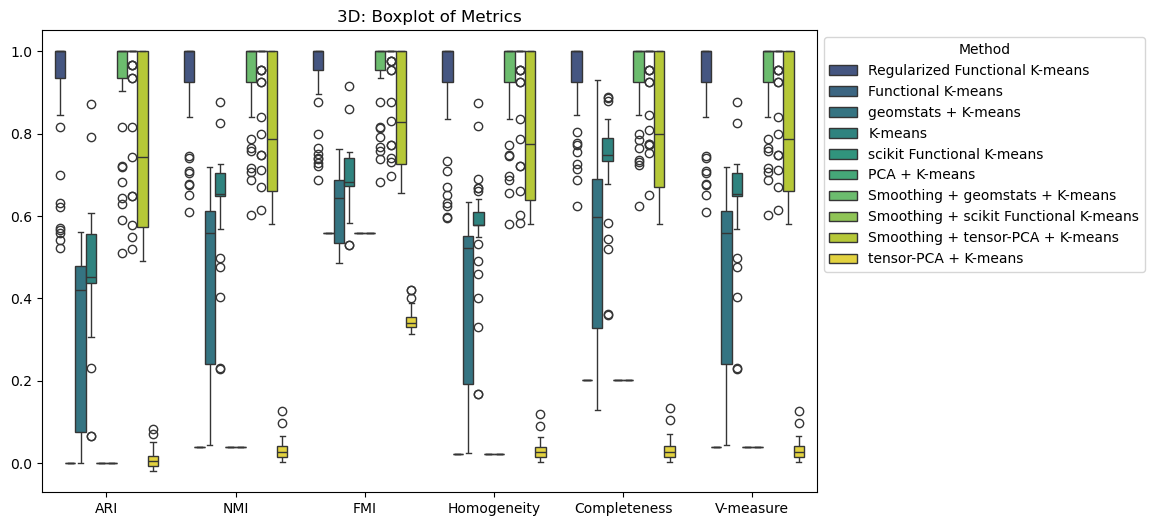

In [19]:
#create dataframe for boxplots
# df_box = pd.DataFrame(columns=["Type", "Curve", "Metric", "Value"])
df_box = []
for curve in ["gauss"]: #, "wave"
    for typ in ["reg", "non_reg"] + methods[dim]:
        for m in metrics:
            values = data[dim][typ][curve][m]["raw"]
            for value in values:
                df_box.append({
                    "Type": better_labels[typ],
                    "Curve": curve,
                    "Metric": m.upper() if m in ["ari", "nmi", "fmi"] else "V-measure" if m == "v_measure" else m.capitalize(),
                    "Value": value
                })

# Convert to DataFrame
df_box = pd.DataFrame(df_box)

light_viridis = sns.color_palette("viridis", as_cmap=True)
colors = [light_viridis(x) for x in np.linspace(0.25, 1, len(df_box["Type"].unique()))]

# Create boxplots for each curve
for curve in ["gauss"]: #, "wave"
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Metric", y="Value", hue="Type", data=df_box[df_box["Curve"] == curve], palette=colors)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f"{dim.upper()}: Boxplot of Metrics")
    plt.legend(title="Method", bbox_to_anchor=(1, 1), loc='upper left')
    # plt.tight_layout()
    plt.savefig(f"{dim}_boxplot.png", bbox_inches='tight')
    plt.show()


In [20]:
# save pd table as a csv file
# df.to_csv(f"competitors_{dim}.csv", index=False)

# Missing

In [21]:
recon_data_dir = "data_reconstructed"
recon_competitor_dir = "output_competitors/reconstructed"

clear_empty_directories(recon_competitor_dir)

methods_recon = {}
for dim in ["1d", "2d", "3d"]:
    dim_path = os.path.join(recon_competitor_dir, dim)
    if not os.path.isdir(dim_path):
        continue
    methods_recon[dim] = {}
    for recon in os.listdir(dim_path):
        recon_path = os.path.join(dim_path, recon)
        if not os.path.isdir(dim_path):
            continue
        methods_recon[dim][recon] = []
        for method in os.listdir(os.path.join(recon_path, "area")):
            method_path = os.path.join(recon_path, "area", method)
            if os.path.isdir(method_path):
                valid = any(
                    os.path.isfile(os.path.join(method_path, subdir, "memberships.csv"))
                    for subdir in ["gauss"] #"wave", 
                )
                if valid:
                    methods_recon[dim][recon].append(method)
            methods_recon[dim][recon].sort()


In [22]:
remove_recon_1d = [] #"dineof"
remove_recon_2d = [] #"dineof"
remove_recon_3d = [] #"dineof"

remove_map = {
    "1d": remove_recon_1d,
    "2d": remove_recon_2d,
    "3d": remove_recon_3d
}

# Perform deletion
for dim, to_remove in remove_map.items():
    for recon in to_remove:
        if recon in methods_recon.get(dim, {}):
            del methods_recon[dim][recon]

In [23]:
data_recon = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))))
metrics = ["ari", "nmi", "fmi", "homogeneity", "completeness", "v_measure"]

for dim in ["1d", "2d", "3d"]: #
    for recon in list(methods_recon[dim]) + ["reg"]: 
        for na_type in ["scatter", "area"]:
            for method in methods_recon[dim][recon] if recon in methods_recon[dim] else ["reg"]:
                for curve in ["gauss"]: #, "wave"
                    if recon == "reg":
                        filepath = os.path.join(output_dir, "missing", dim, na_type, curve, "memberships.csv")
                    else:
                        filepath = os.path.join(recon_competitor_dir, dim, recon, na_type, method, curve, "memberships.csv")
                    print(f"Processing {filepath}")
                    data_recon[dim][recon][na_type][method][curve]["memberships"] = pd.read_csv(filepath, header=None)
                    labels_pred = data_recon[dim][recon][na_type][method][curve]["memberships"]
                    N = labels_pred.shape[0]

                    # Compute raw metrics for each run
                    data_recon[dim][recon][na_type][method][curve]["ari"]["raw"] = [adjusted_rand_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
                    data_recon[dim][recon][na_type][method][curve]["nmi"]["raw"] = [normalized_mutual_info_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
                    data_recon[dim][recon][na_type][method][curve]["fmi"]["raw"] = [fowlkes_mallows_score(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
                    hcv = [homogeneity_completeness_v_measure(labels_true, labels_pred.iloc[i, :].values) for i in range(N)]
                    h, c, v = zip(*hcv)
                    data_recon[dim][recon][na_type][method][curve]["homogeneity"]["raw"] = list(h)
                    data_recon[dim][recon][na_type][method][curve]["completeness"]["raw"] = list(c)
                    data_recon[dim][recon][na_type][method][curve]["v_measure"]["raw"] = list(v)

                    # Compute means
                    for m in metrics:
                        data_recon[dim][recon][na_type][method][curve][m]["mean"] = np.mean(data_recon[dim][recon][na_type][method][curve][m]["raw"])

Processing output_competitors/reconstructed/1d/dineof/scatter/fda_usc/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/scatter/fdacluster/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/scatter/funFEM/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/scatter/mv/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/scatter/scikit/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/scatter/scikit_fpca/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/scatter/scikit_pca/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/area/fda_usc/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/area/fdacluster/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/area/funFEM/gauss/memberships.csv
Processing output_competitors/reconstructed/1d/dineof/area/mv/gauss/memberships.csv


## 1D

In [24]:
dim = "1d"
rows = []
for recon in list(methods_recon[dim]) + ["reg"]:
    for na_type in ["scatter", "area"]:
        for method in methods_recon[dim][recon] if recon in methods_recon[dim] else ["reg"]:
            for curve in ["gauss"]: #, "wave"
                row = {
                    "Reconstruction": recon,
                    "NA Type": na_type,
                    "Method": method,
                    "Curve": curve,
                }
                for m in metrics:
                    row[m.upper()] = data_recon[dim][recon][na_type][method][curve][m]["mean"]
                rows.append(row)

df = pd.DataFrame(rows)
df

,Reconstruction,NA Type,Method,Curve,ARI,NMI,FMI,HOMOGENEITY,COMPLETENESS,V_MEASURE
0,dineof,scatter,fda_usc,gauss,0.174957,0.245377,0.489612,0.227874,0.268094,0.245377
1,dineof,scatter,fdacluster,gauss,0.321931,0.361775,0.566985,0.350121,0.379034,0.361775
2,dineof,scatter,funFEM,gauss,0.014208,0.036134,0.349174,0.035564,0.036749,0.036134
3,dineof,scatter,mv,gauss,0.370118,0.400666,0.579093,0.397608,0.403837,0.400666
4,dineof,scatter,scikit,gauss,0.306856,0.343016,0.554122,0.333914,0.356138,0.343016
5,dineof,scatter,scikit_fpca,gauss,0.312498,0.350077,0.555637,0.341949,0.361866,0.350077
6,dineof,scatter,scikit_pca,gauss,0.337824,0.370407,0.574274,0.360573,0.383955,0.370407
7,dineof,area,fda_usc,gauss,0.165471,0.212053,0.480904,0.197685,0.229714,0.212053
8,dineof,area,fdacluster,gauss,0.248740,0.278969,0.526819,0.266984,0.297466,0.278969
9,dineof,area,funFEM,gauss,0.014534,0.035450,0.351152,0.034759,0.036193,0.035450


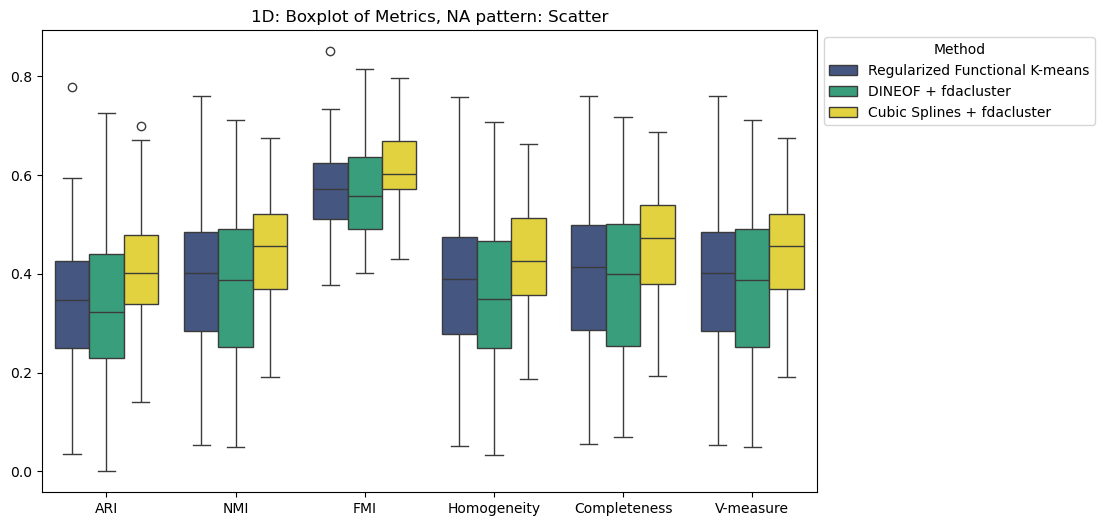

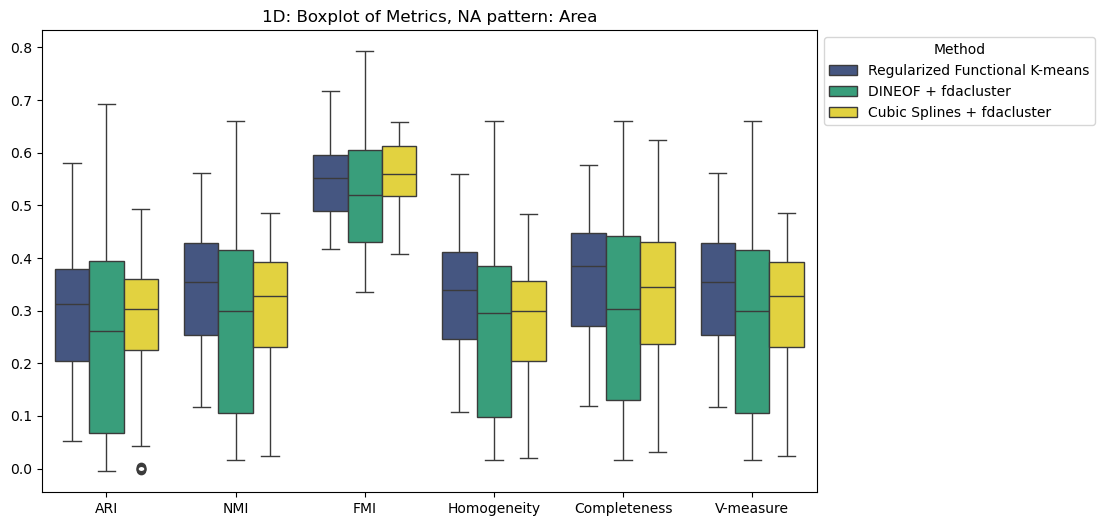

In [25]:
# SELECT THE method WITH THE HIGHEST MEAN ARI FOR EACH RECONSTRUCTION TYPE IN EACH SCENARIO, add them to the box_plot_df
# save as recon_method instead of type
df_box = []
for recon in ["reg"] + list(methods_recon[dim]):
    for na_type in ["scatter", "area"]:
        # for method in methods_recon[dim][recon] if recon in methods_recon[dim] else ["reg"]:
            for curve in ["gauss"]: #, "wave"
                for m in metrics:
                    # select the best method for each reconstruction type
                    if recon == "reg":
                        method = "reg"
                    else:
                        # method = max(methods_recon[dim][recon], key=lambda met: data_recon[dim][recon][na_type][met][curve]["ari"]["mean"])
                        method = "fdacluster"
                    values = data_recon[dim][recon][na_type][method][curve][m]["raw"]
                    for value in values:
                        df_box.append({
                            "Recon_Method": better_labels[f"{recon}_{method}"],
                            "NA Type": na_type,
                            "Curve": curve,
                            "Metric": m.upper() if m in ["ari", "nmi", "fmi"] else "V-measure" if m == "v_measure" else m.capitalize(),
                            "Value": value
                        })

# Convert to DataFrame
df_box = pd.DataFrame(df_box)

light_viridis = sns.color_palette("viridis", as_cmap=True)
colors = [light_viridis(x) for x in np.linspace(0.25, 1, len(df_box["Recon_Method"].unique()))]

# Create boxplots for each curve
for na_type in ["scatter", "area"]:
    for curve in ["gauss"]: #, "wave"
        plt.figure(figsize=(10, 6))
        sns.boxplot(x="Metric", y="Value", hue="Recon_Method", data=df_box[(df_box["Curve"] == curve) & (df_box["NA Type"] == na_type)], palette=colors)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.title(f"{dim.upper()}: Boxplot of Metrics, NA pattern: {na_type.capitalize()}")
        plt.legend(title="Method", bbox_to_anchor=(1, 1), loc='upper left')
        # plt.tight_layout()
        plt.savefig(f"{dim}_{na_type}_boxplot.png", bbox_inches='tight')
        plt.show()

## 2D

In [26]:
dim = "2d"
rows = []
for recon in list(methods_recon[dim]) + ["reg"]:
    for na_type in ["scatter", "area"]:
        for method in methods_recon[dim][recon] if recon in methods_recon[dim] else ["reg"]:
            for curve in ["gauss"]: #, "wave"
                row = {
                    "Reconstruction": recon,
                    "NA Type": na_type,
                    "Method": method,
                    "Curve": curve,
                }
                for m in metrics:
                    row[m.upper()] = data_recon[dim][recon][na_type][method][curve][m]["mean"]
                rows.append(row)

df = pd.DataFrame(rows)
df

,Reconstruction,NA Type,Method,Curve,ARI,NMI,FMI,HOMOGENEITY,COMPLETENESS,V_MEASURE
0,dineof,scatter,geomstats,gauss,0.714135,0.741642,0.812408,0.734414,0.749680,0.741642
1,dineof,scatter,mv,gauss,0.769896,0.786807,0.845584,0.785462,0.788171,0.786807
2,dineof,scatter,scikit,gauss,0.620007,0.674661,0.762200,0.648564,0.707707,0.674661
3,dineof,scatter,scikit_hog,gauss,0.015976,0.037557,0.370075,0.035634,0.039897,0.037557
4,dineof,scatter,scikit_pca,gauss,0.643586,0.696723,0.777103,0.669421,0.733193,0.696723
5,dineof,scatter,tensor_pca,gauss,0.054191,0.080327,0.368425,0.079614,0.081070,0.080327
6,dineof,area,geomstats,gauss,0.560293,0.599886,0.722866,0.579751,0.628047,0.599886
7,dineof,area,mv,gauss,0.636954,0.663157,0.768813,0.650249,0.680091,0.663157
8,dineof,area,scikit,gauss,0.421540,0.488396,0.654524,0.452075,0.544766,0.488396
9,dineof,area,scikit_hog,gauss,0.067736,0.091588,0.390149,0.089086,0.094365,0.091588


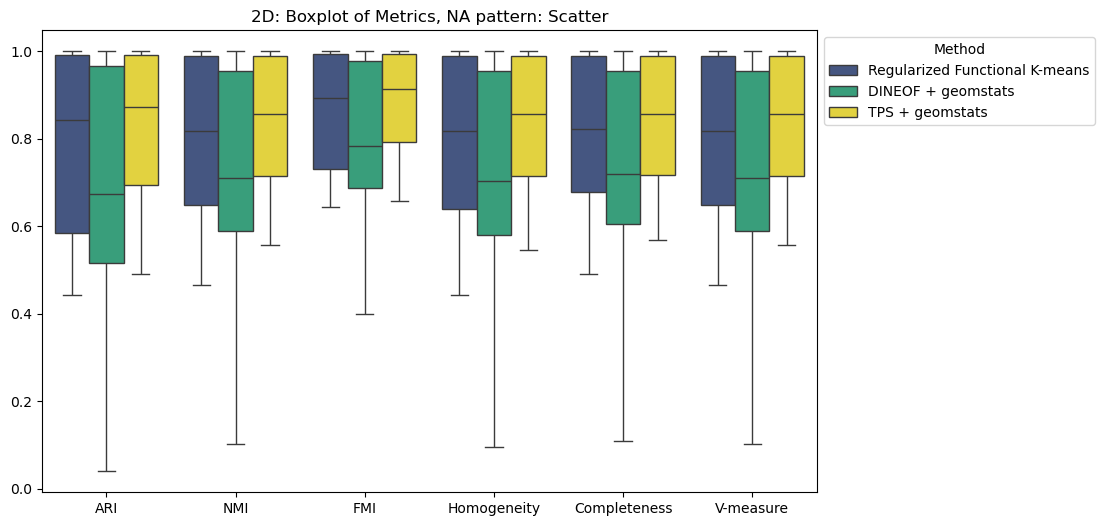

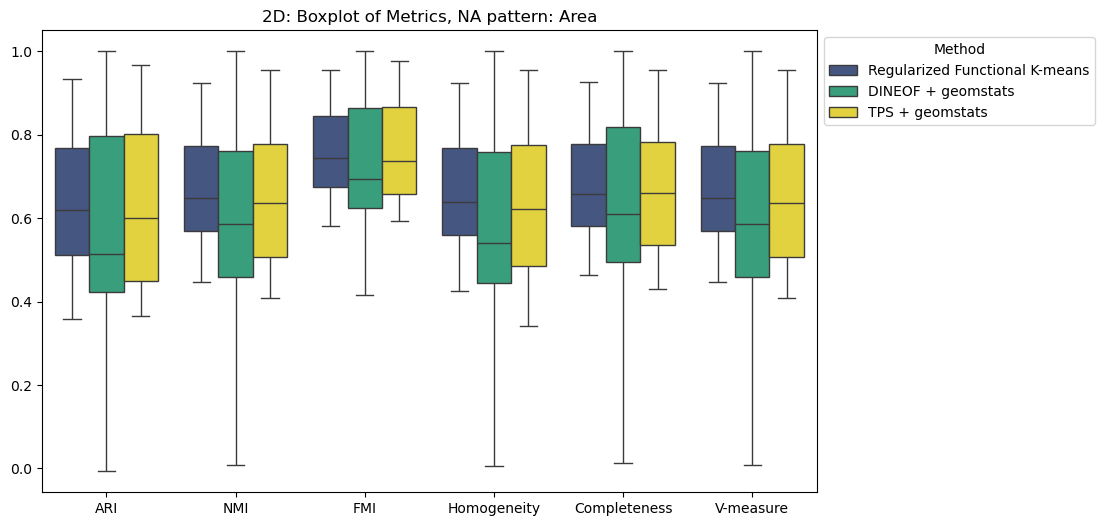

In [27]:
# SELECT THE method WITH THE HIGHEST MEAN ARI FOR EACH RECONSTRUCTION TYPE IN EACH SCENARIO, add them to the box_plot_df
# save as recon_method instead of type
df_box = []
for recon in ["reg"] + list(methods_recon[dim]):
    for na_type in ["scatter", "area"]:
        # for method in methods_recon[dim][recon] if recon in methods_recon[dim] else ["reg"]:
            for curve in ["gauss"]: #, "wave"
                for m in metrics:
                    # select the best method for each reconstruction type
                    if recon == "reg":
                        method = "reg"
                    else:
                        # method = max(methods_recon[dim][recon], key=lambda met: data_recon[dim][recon][na_type][met][curve]["ari"]["mean"])
                        method = "geomstats"
                    values = data_recon[dim][recon][na_type][method][curve][m]["raw"]
                    for value in values:
                        df_box.append({
                            "Recon_Method": better_labels[f"{recon}_{method}"],
                            "NA Type": na_type,
                            "Curve": curve,
                            "Metric": m.upper() if m in ["ari", "nmi", "fmi"] else "V-measure" if m == "v_measure" else m.capitalize(),
                            "Value": value
                        })

# Convert to DataFrame
df_box = pd.DataFrame(df_box)

light_viridis = sns.color_palette("viridis", as_cmap=True)
colors = [light_viridis(x) for x in np.linspace(0.25, 1, len(df_box["Recon_Method"].unique()))]

# Create boxplots for each curve
for na_type in ["scatter", "area"]:
    for curve in ["gauss"]: #, "wave"
        plt.figure(figsize=(10, 6))
        sns.boxplot(x="Metric", y="Value", hue="Recon_Method", data=df_box[(df_box["Curve"] == curve) & (df_box["NA Type"] == na_type)], palette=colors)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.title(f"{dim.upper()}: Boxplot of Metrics, NA pattern: {na_type.capitalize()}")
        plt.legend(title="Method", bbox_to_anchor=(1, 1), loc='upper left')
        # plt.tight_layout()
        plt.savefig(f"{dim}_{na_type}_boxplot.png", bbox_inches='tight')
        plt.show()

## 3D

In [28]:
dim = "3d"
rows = []
for recon in list(methods_recon[dim]) + ["reg"]:
    for na_type in ["scatter", "area"]:
        for method in methods_recon[dim][recon] if recon in methods_recon[dim] else ["reg"]:
            for curve in ["gauss"]: #, "wave"
                row = {
                    "Reconstruction": recon,
                    "NA Type": na_type,
                    "Method": method,
                    "Curve": curve,
                }
                for m in metrics:
                    row[m.upper()] = data_recon[dim][recon][na_type][method][curve][m]["mean"]
                rows.append(row)

df = pd.DataFrame(rows)
df

,Reconstruction,NA Type,Method,Curve,ARI,NMI,FMI,HOMOGENEITY,COMPLETENESS,V_MEASURE
0,dineof,scatter,geomstats,gauss,0.233511,0.338357,0.594365,0.288613,0.428686,0.338357
1,dineof,scatter,mv,gauss,0.411803,0.561512,0.667089,0.501366,0.645744,0.561512
2,dineof,scatter,scikit,gauss,-0.000247,0.040209,0.557924,0.022337,0.201193,0.040209
3,dineof,scatter,scikit_pca,gauss,-0.000247,0.040209,0.557924,0.022337,0.201193,0.040209
4,dineof,scatter,tensor_pca,gauss,0.025446,0.050203,0.355038,0.049034,0.051491,0.050203
5,dineof,area,geomstats,gauss,0.170874,0.271602,0.549498,0.225995,0.354293,0.271602
6,dineof,area,mv,gauss,0.147319,0.252086,0.584031,0.191831,0.410318,0.252086
7,dineof,area,scikit,gauss,0.004495,0.046931,0.558492,0.027657,0.207690,0.046931
8,dineof,area,scikit_pca,gauss,-0.000210,0.040644,0.557569,0.022636,0.200326,0.040644
9,dineof,area,tensor_pca,gauss,0.025496,0.047202,0.355196,0.046174,0.048302,0.047202


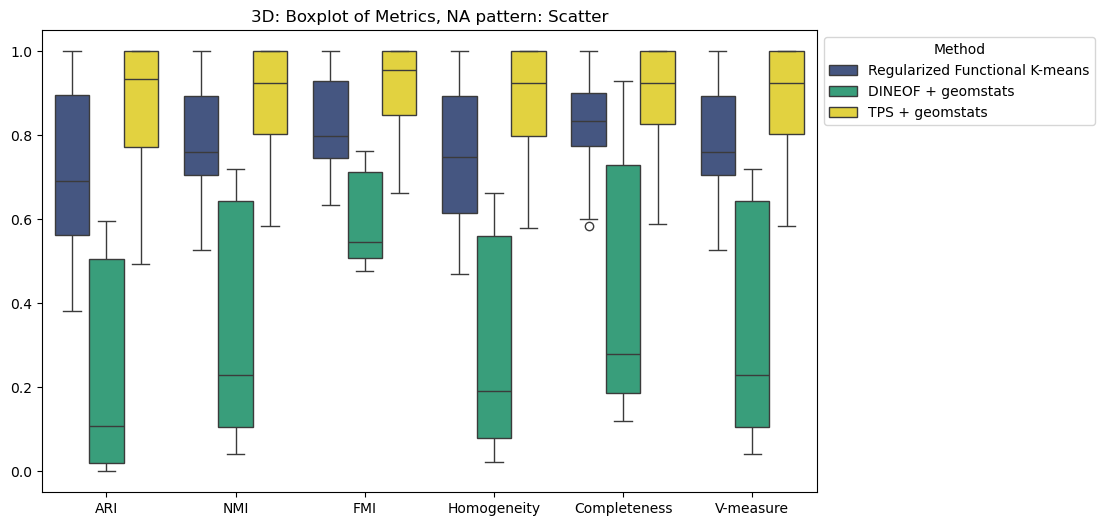

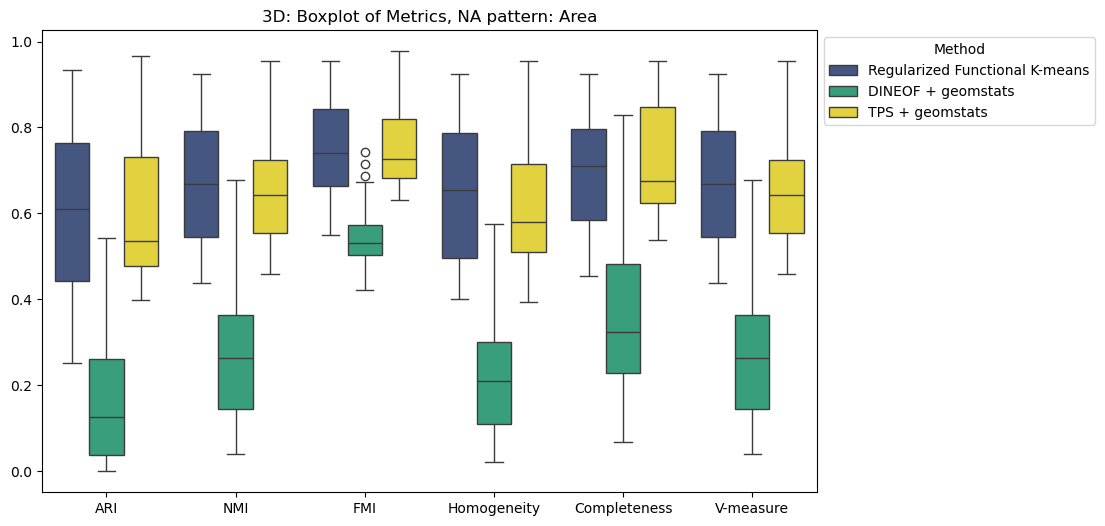

In [29]:
# SELECT THE method WITH THE HIGHEST MEAN ARI FOR EACH RECONSTRUCTION TYPE IN EACH SCENARIO, add them to the box_plot_df
# save as recon_method instead of type
df_box = []
for recon in ["reg"] + list(methods_recon[dim]):
    for na_type in ["scatter", "area"]:
        # for method in methods_recon[dim][recon] if recon in methods_recon[dim] else ["reg"]:
            for curve in ["gauss"]: #, "wave"
                for m in metrics:
                    # select the best method for each reconstruction type
                    if recon == "reg":
                        method = "reg"
                    else:
                        # method = max(methods_recon[dim][recon], key=lambda met: data_recon[dim][recon][na_type][met][curve]["ari"]["mean"])
                        method = "geomstats"
                    values = data_recon[dim][recon][na_type][method][curve][m]["raw"]
                    for value in values:
                        df_box.append({
                            "Recon_Method": better_labels[f"{recon}_{method}"],
                            "NA Type": na_type,
                            "Curve": curve,
                            "Metric": m.upper() if m in ["ari", "nmi", "fmi"] else "V-measure" if m == "v_measure" else m.capitalize(),
                            "Value": value
                        })

# Convert to DataFrame
df_box = pd.DataFrame(df_box)

light_viridis = sns.color_palette("viridis", as_cmap=True)
colors = [light_viridis(x) for x in np.linspace(0.25, 1, len(df_box["Recon_Method"].unique()))]

# Create boxplots for each curve
for na_type in ["scatter", "area"]:
    for curve in ["gauss"]: #, "wave"
        plt.figure(figsize=(10, 6))
        sns.boxplot(x="Metric", y="Value", hue="Recon_Method", data=df_box[(df_box["Curve"] == curve) & (df_box["NA Type"] == na_type)], palette=colors)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.title(f"{dim.upper()}: Boxplot of Metrics, NA pattern: {na_type.capitalize()}")
        plt.legend(title="Method", bbox_to_anchor=(1, 1), loc='upper left')
        # plt.tight_layout()
        plt.savefig(f"{dim}_{na_type}_boxplot.png", bbox_inches='tight')
        plt.show()